In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import torch as th

Global seed set to 0


# Read and plot data

In [2]:
adata =  sc.read('../../scEUseq_organoids/scEU_organoid.h5ad')
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

adata.obs['celltype'] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')
adata.obs['clusters'] = adata.obs['celltype']
adata.layers['spliced'] = adata.layers['su']  + adata.layers['sl']
adata.layers['unspliced'] = adata.layers['uu'] + adata.layers['ul']

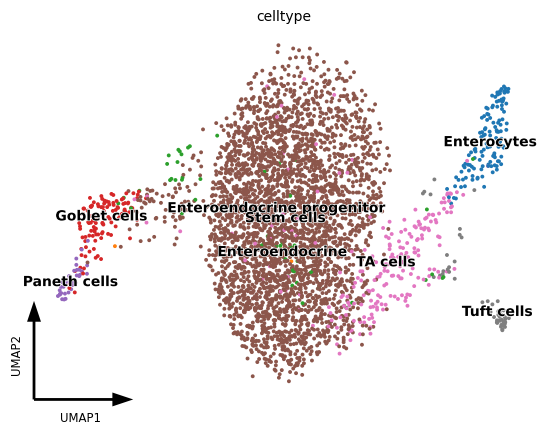

In [3]:
scv.pl.umap(adata, color='celltype', frameon='artist')

# Fit annotated LatentVelo

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, n_top_genes=2000, celltype_key='celltype')

model = ltv.models.AnnotVAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=3,
                      celltypes=len(adata.obs['celltype'].unique()))

epochs, val_ae, val_traj = ltv.train_anvi(model, adata, batch_size = 250,
                                      epochs=50, name='organoid_parameters', grad_clip=100)

Filtered out 3076 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
353 velocity genes used
epoch 0, full loss 237.902, val loss 120.350, ae MSE 1.075, traj MSE 0.474, reg loss -1.924
epoch 1, full loss 120.618, val loss 82.582, ae MSE 0.716, traj MSE 0.254, reg loss -2.990
epoch 2, full loss 92.773, val loss 57.512, ae MSE 0.639, traj MSE 0.223, reg loss -3.407
epoch 3, full loss 69.179, val loss 31.938, ae MSE 0.606, traj MSE 0.215, reg loss -3.786
epoch 4, full loss 39.077, val loss 6.961, ae MSE 0.545, traj MSE 0.215, reg loss -4.046
epoch 5, full loss 19.260, val loss -18.437, ae MSE 0.459, traj MSE 0.215, reg lo

# Output velocities and plot on UMAP

In [5]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True, decoded=True)

computing velocity graph (using 1/16 cores)


  0%|          | 0/3831 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


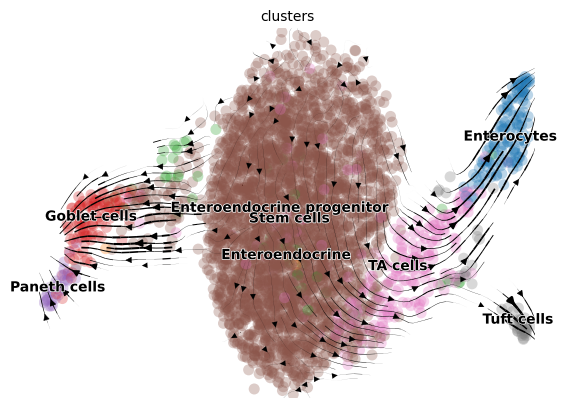

In [6]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, color='clusters', vkey='spliced_velocity')

saving figure to file ../figures/organoid_model_umap_lineages.png


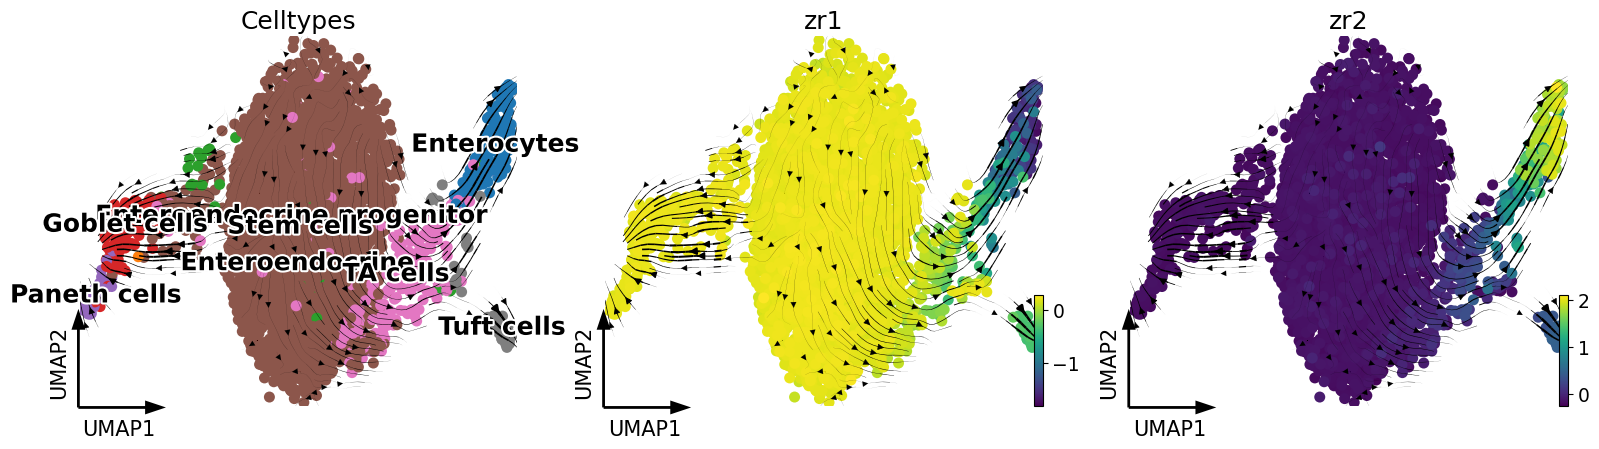

Renamed 'zr' to convention 'X_zr' (adata.obsm).
saving figure to file ../figures/organoid_zr_plot.png


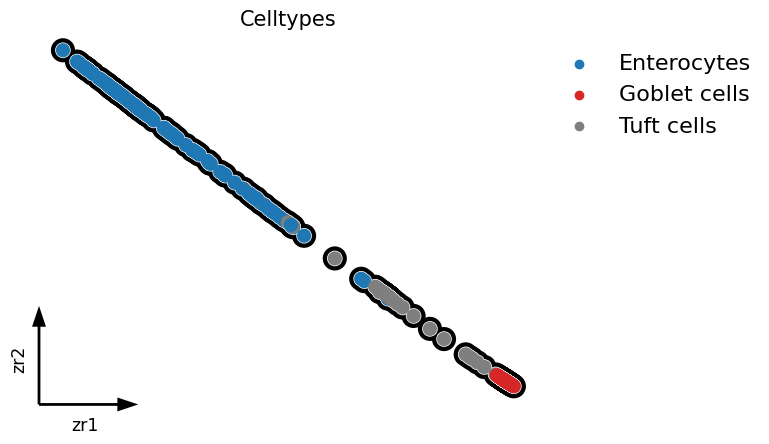

In [7]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters', 'zr1', 'zr2'],                             title=['Celltypes', 'zr1', 'zr2'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/organoid_model_umap_lineages.png')

scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Goblet cells', 'Tuft cells', 'Enterocytes'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True, save='../figures/organoid_zr_plot.png')

In [12]:
# save fit
latent_adata.write('../benchmark/real_data/fits/organoid_latent_adata.h5ad')

# Compute CBDir transition scores

In [13]:
organoid_edges = [
    ('Stem cells', 'TA cells'), 
    ('Stem cells', 'Goblet cells'),
    ('Stem cells', 'Tuft cells'), 
    ('TA cells', 'Enterocytes')]

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/3831 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [14]:
latent_adata.obsm['X_pca'] = adata.obsm['X_pca'].copy()
latent_adata.obsm['latent'] = latent_adata.X.copy()
latent_adata.obsm['spliced_velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
organoid_latent = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', organoid_edges,
                                                    x_emb='X_pca', majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


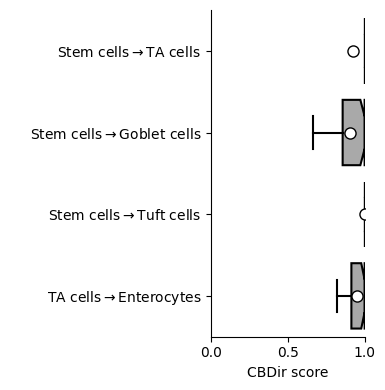

In [15]:
import matplotlib.pyplot as plt
#fig,ax=plt.subplots()
ax=ltv.pl.transition_scores(organoid_latent, raw=True)
ax.set(xlim=(0,1))
plt.tight_layout()
plt.show()

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/organoid_umap.png


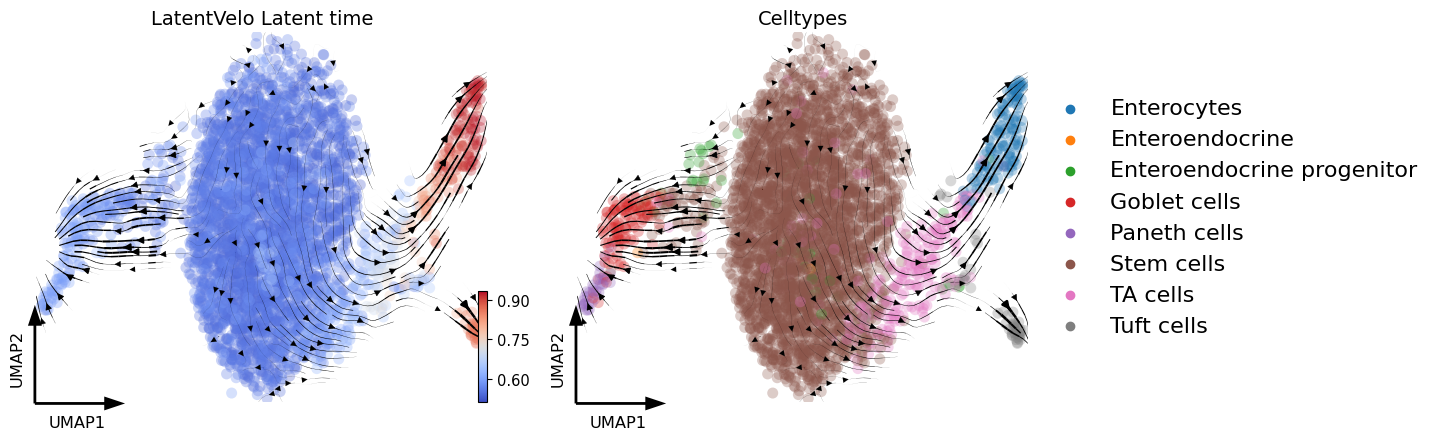

In [16]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 title=['LatentVelo Latent time', 'Celltypes'],
                                color=['latent_time', 'clusters'], fontsize=14,
              legend_fontsize=16, legend_loc='right', color_map='coolwarm',
                                frameon='artist', save='../figures/organoid_umap.png')